## Data Reader

In [1]:
# data_key = "ml-1m"
data_key = 'BX'
ROOT="/home/sl1471/workspace/experiments/" + data_key
setting = {'lr': 0.0001, 
           'l2_coef': 0.01, 
           'loss': 'pairwisebpr', 
           'fair_lambda': '0.', 
           'group_feature': 'activity'}
modelName = 'MF'

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from reader.FedRecReader import FedRecReader
import argparse
from argparse import Namespace

log_path = ROOT + f"/logs/fairtrain_and_eval_{modelName}_lr{setting['lr']}_reg{setting['l2_coef']}_loss{setting['loss']}_lambda{setting['fair_lambda']}_g{setting['group_feature']}.log"

def read_line_number(file_path, line_num):
    with open(file_path, 'r') as fin:
        for i,line in enumerate(fin):
            if i == line_num:
                return line.strip()
    return ""
args = eval(read_line_number(log_path, 1))
print(args)

Namespace(cuda=3, seed=9, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/BX/models/MF_lr0.0001_reg0.01_pairwisebpr_lambda0._gactivity.pkl', loss='pairwisebpr', l2_coef=0.01, emb_size=32, data_file='/home/sl1471/workspace/experiments/BX/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/BX/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/BX/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/BX/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/BX/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/BX/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/BX/meta_data/item_fields.vocab', n_neg=1, n_neg_val=100, n_neg_test=-1, n_round=1, optimizer='Adam', epoch=30, check_epoch=1, lr=0.0001, batch_size=512, eval_batch_size=1, temper=6, with_

In [3]:
reader = FedRecReader(args)

Loading train data file. Done.
Loading val data file. Done.
Loading test data file. Done.
   UserID      ItemID  Response  Timestamp
0  277195  0060391626        10       1083
1  277195  0060502258         0       1084
2  277195  0060987561         0       1089
3  277195  0316666343         0       1098
4  277195  0316734837         0       1099
Load field meta and vocab file.
Load vocab from : /home/sl1471/workspace/experiments/BX/meta_data/user_fields.vocab
User fields: ['UserID', 'Location', 'AgeGroup']
Load vocab from : /home/sl1471/workspace/experiments/BX/meta_data/item_fields.vocab
Item fields: ['ItemID', 'Year', 'Publisher']
Appending history info
Buffer negative training and validation samples


100%|██████████| 2560/2560 [00:04<00:00, 583.32it/s]


In [4]:
from model.fair_rec.FairUserGroupPerformance import get_user_group_info

# group_feature = 'AgeGroup'
group_feature = 'activity'
group_dict, feature_values = get_user_group_info(reader, group_feature)

user activity: 656(A) -- 1904(I), threshold (72.35625)


## Model

In [5]:
from model.baselines import *
from model.fed_rec import *

device = 'cuda:2'
modelClass = eval('{0}.{0}'.format(modelName))
model = modelClass(args, reader, device)
model.load_from_checkpoint(args.model_path, with_optimizer = False)
model = model.to(device)
model.device = device

embedding: tensor([[-0.0056,  0.0228,  0.0220,  ..., -0.0166,  0.0186,  0.0279],
        [ 0.0044,  0.0434, -0.0030,  ..., -0.0036, -0.0498, -0.0309],
        [ 0.0385, -0.0153, -0.0325,  ..., -0.0407,  0.0103,  0.0107],
        ...,
        [ 0.0558, -0.0079,  0.0205,  ...,  0.0328, -0.0358,  0.0217],
        [ 0.0067,  0.0584,  0.0386,  ...,  0.0380,  0.0423,  0.0278],
        [-0.0111,  0.0208, -0.0058,  ...,  0.0199,  0.0462, -0.0032]])
embedding: tensor([[ 0.0078, -0.0011,  0.0029,  ...,  0.0340, -0.0179,  0.0033],
        [-0.0412,  0.0233,  0.0109,  ...,  0.0042,  0.0354, -0.0109],
        [-0.0017,  0.0143, -0.0228,  ...,  0.0099, -0.0079, -0.0493],
        ...,
        [-0.0261, -0.0249,  0.0400,  ..., -0.0013,  0.0272, -0.0529],
        [-0.0056,  0.0023,  0.0051,  ...,  0.0009,  0.0337, -0.0065],
        [-0.0249,  0.0066,  0.0092,  ...,  0.0134,  0.0301,  0.0039]])
Load (checkpoint) from /home/sl1471/workspace/experiments/BX/models/MF_lr0.0001_reg0.01_pairwisebpr_lambda0._g

## Evaluate

In [6]:
method = 'diff'
selected_metric = 'AUC'
at_k_list = [1,10,20,50]
group_name = f"user_group_{group_feature}"
eval_sample_p = 1.0
fair_rho = args.fair_rho
fair_lambda = args.fair_lambda

In [7]:
from torch.utils.data import DataLoader
import torch
import numpy as np

from reader.BaseReader import worker_init_func
from task.TopK import calculate_ranking_metric

print(f"Fairness evaluation (G - {group_feature}):")
reader.set_phase("test")
eval_data = reader.get_eval_dataset()
eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                         batch_size = 1, shuffle = False, pin_memory = False, 
                         num_workers = eval_data.n_worker)

report = {group_name: {v: {} for v in feature_values}}
print(f"\tGroup feature:{report.keys()}")
with torch.no_grad():
    for i, batch_data in enumerate(eval_loader):
        if np.random.random() <= eval_sample_p and "no_item" not in batch_data:
            uid = batch_data["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
            # predict
            feed_dict = model.wrap_batch(batch_data)
            out_dict = model.forward(feed_dict, return_prob = True)
            pos_probs, neg_probs = out_dict["probs"], out_dict["neg_probs"]
            # metrics
            ranking_report = calculate_ranking_metric(pos_probs.view(-1), neg_probs.view(-1), at_k_list)
            # record evaluation info for user groups of each selected field
            G = group_dict[uid]
            for metric,val in ranking_report.items():
                if metric not in report[group_name][G]:
                    report[group_name][G][metric] = (val,1)
                else:
                    report[group_name][G][metric] = (report[group_name][G][metric][0] + val, 
                                                     report[group_name][G][metric][1] + 1)  
# aggregate each metric
# {"user_group_xxx": {feature_value: {metric: (value_sum, value_count)}}}
# --> {"user_group_xxx": {feature_value: {metric: value_sum / value_count}}}
GD = report[group_name]
for group_value, metric_dict in GD.items():
    GD[group_value] = {metric: val_tuple[0]/val_tuple[1] if val_tuple[1] !=0 else 0 \
                               for metric, val_tuple in metric_dict.items()}
# calculate fairness evaluation metric
#         aggregate_report = {metric: [group_dict[G][metric] for G in feature_values] \
#                             for metric in group_dict[feature_values[0]]}
for metric in GD[feature_values[0]]:
    performance_list = [GD[G][metric] for G in feature_values]
    F = []
    if method == 'diff':
        max_abs = max(abs(max(performance_list)), abs(min(performance_list))) + 1e-7
        for i,A in enumerate(performance_list):
            for j in range(i+1,len(performance_list)):
                F.append(abs(A-performance_list[j]) / max_abs)
    elif method == 'original':
        for i,A in enumerate(performance_list):
            for j in range(i+1,len(performance_list)):
                F.append(fair_lambda * (abs(A-performance_list[j]) ** fair_rho))
    report[metric] = np.mean(F)


Fairness evaluation (G - activity):
	Group feature:dict_keys(['user_group_activity'])


100%|██████████| 2559/2559 [02:43<00:00, 15.64it/s]


In [8]:
report

{'user_group_activity': {'active': {'HR@1': 0.5368421052631579,
   'P@1': 0.5368421052631579,
   'RECALL@1': 0.04789311501540636,
   'F1@1': 0.08749542910801737,
   'NDCG@1': 0.5368421052631579,
   'HR@10': 0.5368421052631579,
   'P@10': 0.09578947534686641,
   'RECALL@10': 0.08689323887228965,
   'F1@10': 0.0897038444484535,
   'NDCG@10': 0.17450610399246216,
   'HR@20': 0.5368421052631579,
   'P@20': 0.047894737673433205,
   'RECALL@20': 0.08689323887228965,
   'F1@20': 0.060809793323278426,
   'NDCG@20': 0.1590225647938879,
   'HR@50': 0.5368421052631579,
   'P@50': 0.019157894387056954,
   'RECALL@50': 0.08689323887228965,
   'F1@50': 0.03105707176421818,
   'NDCG@50': 0.15808545413770173,
   'MR': 165.09447053608142,
   'MRR': 0.0645694401688065,
   'AUC': 0.5329798161105092},
  'inactive': {'HR@1': 0.28731045490822027,
   'P@1': 0.28731045490822027,
   'RECALL@1': 0.09465790128503336,
   'F1@1': 0.13757331902421385,
   'NDCG@1': 0.28731045490822027,
   'HR@10': 0.2873104549082202

### Recommendation Unfairness

* Group unfairness: 
    * User:
        * Performance difference: abs(mean(performance|user in G) - mean(performance|user not in G))
    * Item:
        * Performance difference: abs(mean(performance|item in G) - mean(performance|item not in G))
        * Exposure difference: abs(mean(exposure|item in G) - mean(exposure|item not in G))

In [9]:
stats = report[group_name]
for G in feature_values:
    print(G,":")
    print(stats[G])

active :
{'HR@1': 0.5368421052631579, 'P@1': 0.5368421052631579, 'RECALL@1': 0.04789311501540636, 'F1@1': 0.08749542910801737, 'NDCG@1': 0.5368421052631579, 'HR@10': 0.5368421052631579, 'P@10': 0.09578947534686641, 'RECALL@10': 0.08689323887228965, 'F1@10': 0.0897038444484535, 'NDCG@10': 0.17450610399246216, 'HR@20': 0.5368421052631579, 'P@20': 0.047894737673433205, 'RECALL@20': 0.08689323887228965, 'F1@20': 0.060809793323278426, 'NDCG@20': 0.1590225647938879, 'HR@50': 0.5368421052631579, 'P@50': 0.019157894387056954, 'RECALL@50': 0.08689323887228965, 'F1@50': 0.03105707176421818, 'NDCG@50': 0.15808545413770173, 'MR': 165.09447053608142, 'MRR': 0.0645694401688065, 'AUC': 0.5329798161105092}
inactive :
{'HR@1': 0.28731045490822027, 'P@1': 0.28731045490822027, 'RECALL@1': 0.09465790128503336, 'F1@1': 0.13757331902421385, 'NDCG@1': 0.28731045490822027, 'HR@10': 0.28731045490822027, 'P@10': 0.037031125975958555, 'RECALL@10': 0.11453527509452625, 'F1@10': 0.05372176149894215, 'NDCG@10': 0.1

In [14]:
metrics = [selected_metric] \
            + [f'HR@{k}' for k in at_k_list] \
            + [f'RECALL@{k}' for k in at_k_list] \
            + [f'NDCG@{k}' for k in at_k_list]
for i,G0 in enumerate(feature_values):
    print(G0,":")
    for G1 in feature_values[i+1:]:
        print('  ',G1,':')
        for m in metrics:
            a,b = stats[G0][m], stats[G1][m]
            diff = a - b
            ratio = diff * 100 / max(a,b)
            print(f"    {m}:\t|{a} - {b}| = {diff}, {ratio}%")

active :
   inactive :
    AUC:	|0.5329798161105092 - 0.558784012776113| = -0.02580419666560385, -4.6179196390041986%
    HR@1:	|0.5368421052631579 - 0.28731045490822027| = 0.24953165035493763, 46.481385850429554%
    HR@10:	|0.5368421052631579 - 0.28731045490822027| = 0.24953165035493763, 46.481385850429554%
    HR@20:	|0.5368421052631579 - 0.28731045490822027| = 0.24953165035493763, 46.481385850429554%
    HR@50:	|0.5368421052631579 - 0.28731045490822027| = 0.24953165035493763, 46.481385850429554%
    RECALL@1:	|0.04789311501540636 - 0.09465790128503336| = -0.046764786269627004, -49.40399653359009%
    RECALL@10:	|0.08689323887228965 - 0.11453527509452625| = -0.0276420362222366, -24.134081137381962%
    RECALL@20:	|0.08689323887228965 - 0.11453527509452625| = -0.0276420362222366, -24.134081137381962%
    RECALL@50:	|0.08689323887228965 - 0.11453527509452625| = -0.0276420362222366, -24.134081137381962%
    NDCG@1:	|0.5368421052631579 - 0.28731045490822027| = 0.24953165035493763, 46.48

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_fairness(stats, group_field, vocab, ncol = 4):
    '''
    @input:
    - stats: {field_name: {key: {metric: val}}}
    - group_field: field_name
    - vocab: {field_name: {key: idx}}
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    value_dict = stats[group_field]
    X = list(value_dict.keys())
    reversed_vdict = {}
    for k,v in vocab[group_field].items():
        if v not in reversed_vdict:
            reversed_vdict[v] = str(k)
        else:
            reversed_vdict[v] += ("," + str(k))
    print(reversed_vdict)
    X_labels = [reversed_vdict[x] for x in X]
    metrics = value_dict[X[0]]
    N = len(metrics) # number of metrics
    
    plt.figure(figsize = (16, 3.5*((N-1)//ncol+1)))
    for i,metric in enumerate(metrics):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        field_stats = stats[group_field] # {key: {metric: val}}
        Y = [field_stats[x][metric] for x in X]
        xt = np.arange(len(X))
        plt.bar(xt,Y)
        plt.title(metric)
        plt.xticks(xt,X_labels)
        plt.yticks(fontsize=7)
        scale = 1e-7 + np.max(Y) - np.min(Y)
        if len(X) >=2:
#             plt.ylim(0, np.max(Y) + scale * 0.05)
            plt.ylim(0, np.max(Y)*1.1)
        else:
            plt.ylim(0,max(1.,np.max(Y)*1.05))
    plt.show()

{'active': 'A', 'inactive': 'INA'}


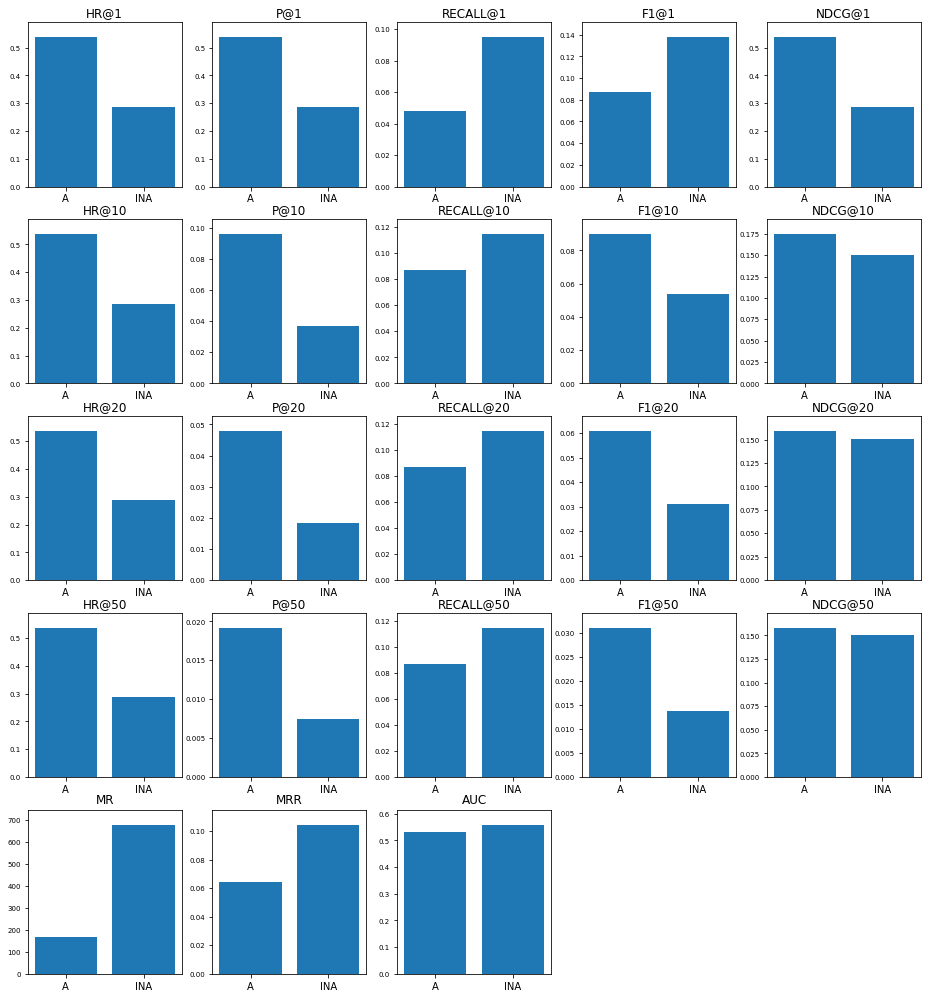

In [16]:
group_labels = {"user_group_activity": {"A": "active" , "INA": "inactive"}} if group_name == "user_group_activity" else {}
plot_fairness({group_name: stats}, group_name, group_labels, ncol=5)